In [92]:
%pip install pandas
%pip install -U scikit-learn
%pip install xgboost
%pip install seaborn
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from IPython.display import display
# ----------------------------
# Config
# ----------------------------
WINDOW_SIZE = 2  # use past 2 days
RANDOM_STATE = 8
WEIGHTED_RATIO_MULTIPLIER = 1.5
CUSTOM_THRESHOLD = 0.25  # custom threshold for classification

# Define base features (original, non-lagged)
base_features = [
    "rainfall_3day_cumulative_mm",
    "rainfall_5day_cumulative_mm",
    "rainfall_7day_cumulative_mm",
    "rainfall_max_mm",
    "rainfall_mean_mm",
    "rainfall_std_mm",
    "soil_moisture_top10cm_mm",
    "subsurface_runoff_mm",
    "surface_runoff_mm",
]

def preprocess_date(file_str):
    
    # ----------------------------
    # 1. Load Data
    # ----------------------------
    df = pd.read_csv(file_str, parse_dates=["date"],
                 date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%Y"))
    df.drop(columns=[".geo", "system:index"], inplace=True)  # drop index column if exists
    flood_dates = pd.read_csv("flood_ground_truth.csv", parse_dates=["Flood Date"])

    # Add flood label (binary)
    df["is_flood"] = df["date"].isin(flood_dates["Flood Date"]).astype(int)

    # Drop rows with date before 2000-01-01 due to missing moitsture data
    df = df[df["date"] >= "2000-01-01"]
    # Sort by time to maintain chronological order
    df = df.sort_values("date").reset_index(drop=True)
    display(df.head())
    
    # ----------------------------
    # 2. Handle Missing / Fake Zero Values
    # ----------------------------
    # Replace 0 with NaN (only if 0 indicates missing)
    for col in base_features:
        df[col] = df[col].replace(0, np.nan)
        df[col] = df[col].replace(-9999, np.nan)

    # Create 'day-of-year' for seasonal imputation
    df['doy'] = df['date'].dt.dayofyear

    # Impute NaNs using seasonal (day-of-year) mean
    for col in base_features:
        seasonal_avg = df.groupby('doy')[col].transform('mean')
        df[col] = df[col].fillna(seasonal_avg)

    # Drop the helper column
    df.drop(columns=['doy'], inplace=True)

    # ----------------------------
    # 3. Create Temporal Lag Features
    # ----------------------------
    for lag in range(1, WINDOW_SIZE + 1):
        for col in base_features:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Drop initial rows that have NaNs due to lagging
    df = df.dropna().reset_index(drop=True)
    # Print the shape of the DataFrame after preprocessing
    print(f"DataFrame shape after preprocessing: {df.shape}")
    df.to_csv("preprocess_features.csv", index=False)
    return df


# ----------------------------
# 4. Prepare Train/Test Sets (Chronological Split)
# ----------------------------
df = preprocess_date("dataset/Flood_Features.csv")
split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# X: use only lag features
X_train = train_df.drop(columns=["date", "is_flood"] + base_features)
X_test = test_df.drop(columns=["date", "is_flood"] + base_features)
y_train = train_df["is_flood"]
y_test = test_df["is_flood"]

/tmp/ipykernel_90221/1480803663.py:34: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(file_str, parse_dates=["date"],


,date,rainfall_3day_cumulative_mm,rainfall_5day_cumulative_mm,rainfall_7day_cumulative_mm,rainfall_max_mm,rainfall_mean_mm,rainfall_std_mm,soil_moisture_top10cm_mm,subsurface_runoff_mm,surface_runoff_mm,is_flood
0,2000-01-01,1.552315,1.552315,1.552315,9.633512,1.780658,3.177049,34.776390,1.188814,0.003935,0
1,2000-01-02,7.195744,7.195744,7.195744,20.349800,5.878247,6.757485,35.755472,2.805128,0.000000,0
2,2000-01-03,7.195744,7.195744,7.195744,0.000000,0.000000,0.000000,35.286133,2.655712,0.000000,0
3,2000-01-04,5.643429,7.195744,7.195744,0.000000,0.000000,0.000000,34.918411,2.456230,0.000000,0
4,2000-01-05,0.000000,7.195744,7.195744,0.000000,0.000000,0.000000,34.613084,2.238542,0.000000,0


DataFrame shape after preprocessing: (9130, 29)


In [49]:
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
# ----------------------------
# 5. Apply SMOTE for Imbalanced Data
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def apply_smote(X_train_scaled, y_train):
    # Apply SMOTE to training set only
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)
    
    print("Before SMOTE:", np.bincount(y_train))
    print("After SMOTE:", np.bincount(y_resampled))
    
    return X_resampled, y_resampled

def confusion_matrix_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Define labels
    labels = ["No Flood", "Flood"]

    # Plot nicely
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Before SMOTE: [6241  150]
After SMOTE: [6241 6241]


/home/kaos/AfterGradEx/time_series/flood_predicition/.venv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2719
           1       0.04      0.80      0.08        20

    accuracy                           0.86      2739
   macro avg       0.52      0.83      0.50      2739
weighted avg       0.99      0.86      0.92      2739



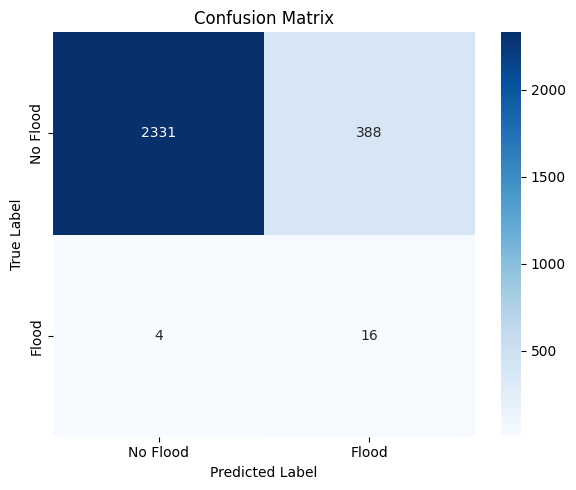

ROC AUC Score: 0.8992644354542111


In [50]:
def xgboost_classification_report(X_train_scaled, X_test_scaled, y_train, y_test):

    # ----------------------------
    # 6. Train XGBoost Classifier
    # ----------------------------
    # Calculate class imbalance ratio
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() * WEIGHTED_RATIO_MULTIPLIER

    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
           eval_metric='aucpr',
        random_state=RANDOM_STATE
    )

    xgb.fit(X_train_scaled, y_train)

    # ----------------------------
    # 7. Evaluate Model
    # ----------------------------
    # Predict probability of flood (class 1)
    y_prob = xgb.predict_proba(X_test_scaled)[:, 1]
    # Apply custom threshold
    y_pred = (y_prob > CUSTOM_THRESHOLD).astype(int)

    print(classification_report(y_test, y_pred))
    confusion_matrix_report(y_test, y_pred)
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

X_train_resampled, y_train_resampled = apply_smote(X_train_scaled, y_train)
xgboost_classification_report(X_train_resampled, X_test_scaled, y_train_resampled, y_test)


In [7]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 51.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 44.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 42.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 67.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 66.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 77.2 MB/s et

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU
Epoch [1/30], Loss: 0.3996
Epoch [2/30], Loss: 0.3109
Epoch [3/30], Loss: 0.2899
Epoch [4/30], Loss: 0.2744
Epoch [5/30], Loss: 0.2754
Epoch [6/30], Loss: 0.2543
Epoch [7/30], Loss: 0.2515
Epoch [8/30], Loss: 0.2324
Epoch [9/30], Loss: 0.2362
Epoch [10/30], Loss: 0.2291
Epoch [11/30], Loss: 0.2301
Epoch [12/30], Loss: 0.2188
Epoch [13/30], Loss: 0.2073
Epoch [14/30], Loss: 0.2066
Epoch [15/30], Loss: 0.1997
Epoch [16/30], Loss: 0.2028
Epoch [17/30], Loss: 0.1979
Epoch [18/30], Loss: 0.2116
Epoch [19/30], Loss: 0.1858
Epoch [20/30], Loss: 0.1870
Epoch [21/30], Loss: 0.1872
Epoch [22/30], Loss: 0.1973
Epoch [23/30], Loss: 0.1831
Epoch [24/30], Loss: 0.1753
Epoch [25/30], Loss: 0.1720
Epoch [26/30], Loss: 0.1699
Epoch [27/30], Loss: 0.1706
Epoch [28/30], Loss: 0.1664
Epoch [29/30], Loss: 0.1699
Epoch [30/30], Loss: 0.1623


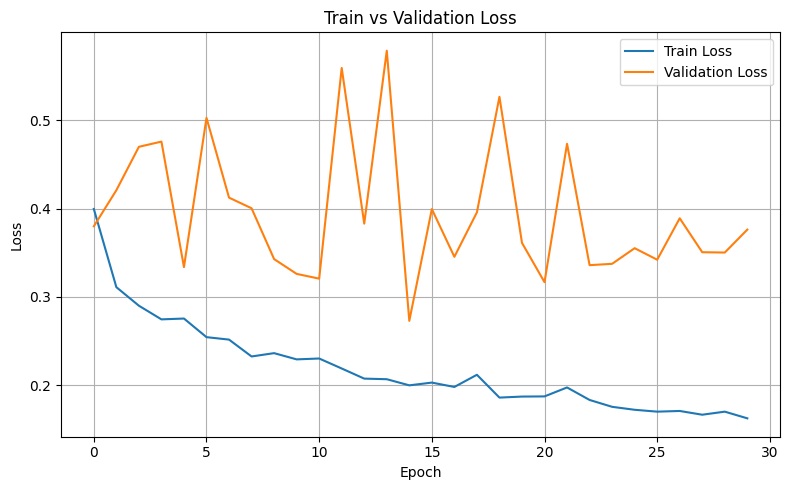

              precision    recall  f1-score   support

    No Flood       1.00      0.84      0.91      2719
       Flood       0.03      0.70      0.06        20

    accuracy                           0.84      2739
   macro avg       0.51      0.77      0.49      2739
weighted avg       0.99      0.84      0.91      2739



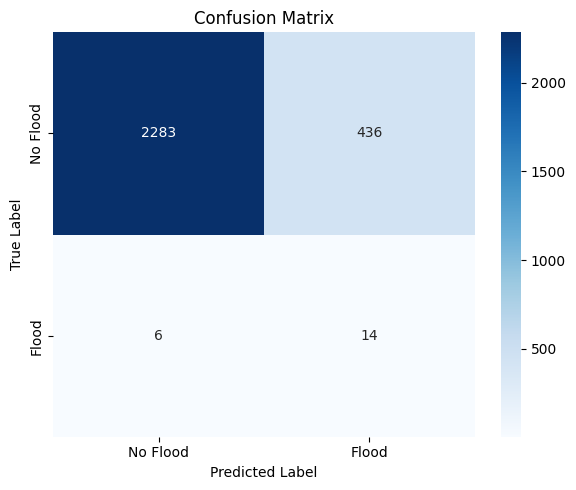

ROC AUC: 0.8075027583670468


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Check CUDA (optional)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# ----------------------------
# 8. Build MLP Classifier
# ----------------------------

# -----------------------------------------
# 1. Convert to torch tensors (after SMOTE + scaling)
# -----------------------------------------
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

# -----------------------------------------
# 2. Define the MLP model
# -----------------------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1)
            # nn.Sigmoid() # No sigmoid here!
        )

    def forward(self, x):
        return self.net(x)

model = MLPClassifier(input_dim=X_train.shape[1])

# -----------------------------------------
# 3. Handle class imbalance using pos_weight
# -----------------------------------------
neg = (y_train_tensor == 0).sum()
pos = (y_train_tensor == 1).sum()
pos_weight = torch.tensor([(neg / pos)], dtype=torch.float32) * WEIGHTED_RATIO_MULTIPLIER
# ----------------------------
# 8. Train the model
# ----------------------------
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------------------
# 4. Training loop
# -----------------------------------------
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  # raw logits
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_running_loss += val_loss.item()
    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

# -----------------------------------------
# 5. Evaluation
# -----------------------------------------
def plot_learning(train_losses, val_losses, model):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    model.eval()

plot_learning(train_losses, val_losses, model)

def evaluate_model(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        logits = model(X_test_tensor)                      # raw outputs
        probs = torch.sigmoid(logits).numpy().flatten()    # convert to [0,1] range

    # ✅ Use custom threshold
    y_pred = (probs > CUSTOM_THRESHOLD).astype(int)

    y_true = y_test_tensor.numpy().flatten()

    # Metrics
    print(classification_report(y_true, y_pred, target_names=["No Flood", "Flood"]))
    confusion_matrix_report(y_test, y_pred)
    print("ROC AUC:", roc_auc_score(y_true, probs))
    
evaluate_model(model, X_test_tensor, y_test_tensor)
